In [1]:
#mount google drive when on google colab and set working directory

import sys
import os

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/music_speech/')

working_dir = os.getcwd()
print(f'\nWorking directory: {working_dir}')


Working directory: /Users/kraehenb/music_speech


In [2]:
#check working directory and repo (git clone git@github.com:jkcas22/music_speech.git)

!{sys.executable} -m pip install gitpython
import git

repo = ['git@github.com:jkcas22/music_speech.git', 'https://github.com/jkcas22/music_speech.git']

if git.Repo(working_dir).remotes.origin.url in repo:
    print(f'\nRepository and working directory are fine.')
else:
    print(f'\nRepository: {git.Repo(working_dir).remotes.origin.url}')


Repository and working directory are fine.


In [3]:
#initialize environment, load modules/libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from scipy.signal import hann


#import python code from seperate files
from helpers.fourier_transform import load_wav, dft_logmag

2023-03-06 12:01:58.966808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
music_dir = './data/music_wav'
music = [os.path.join(music_dir, file) for file in os.listdir(music_dir) if file.endswith('.wav')]

speech_dir = './data/speech_wav'
speech = [os.path.join(speech_dir, file) for file in os.listdir(speech_dir) if file.endswith('.wav')]

In [5]:
speech_sounds = load_wav(speech)
music_sounds = load_wav(music)

# 22 kHz
# 16 Bit
# 30 s

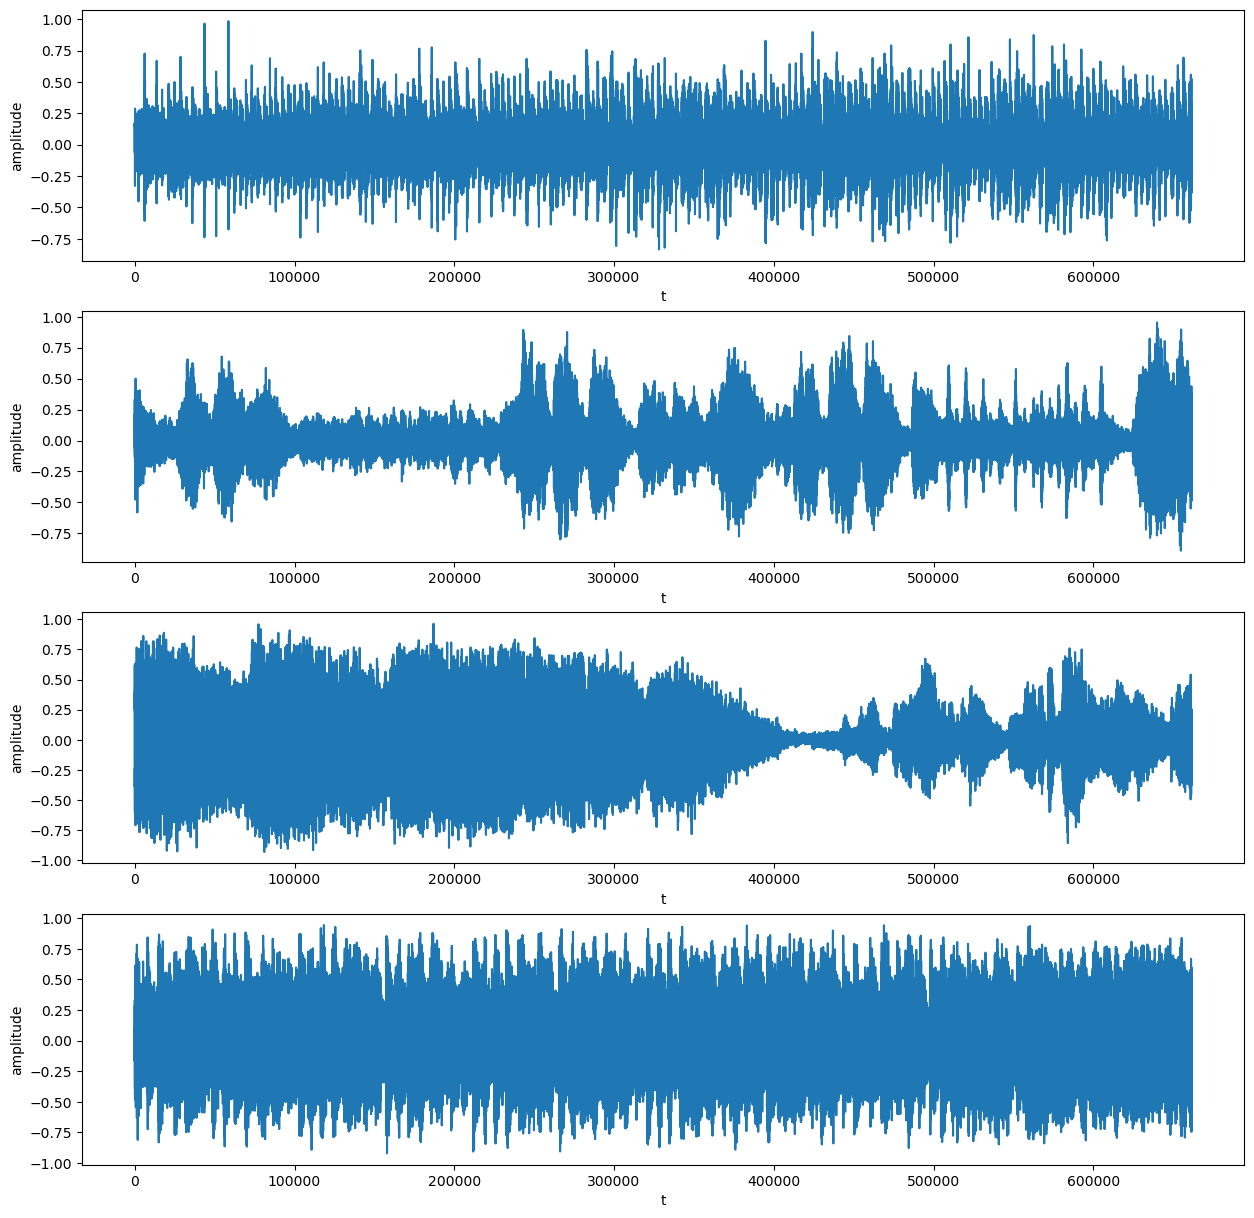

In [6]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(music_sounds[i])
    plt.xlabel('t')
    plt.ylabel('amplitude')
plt.show()

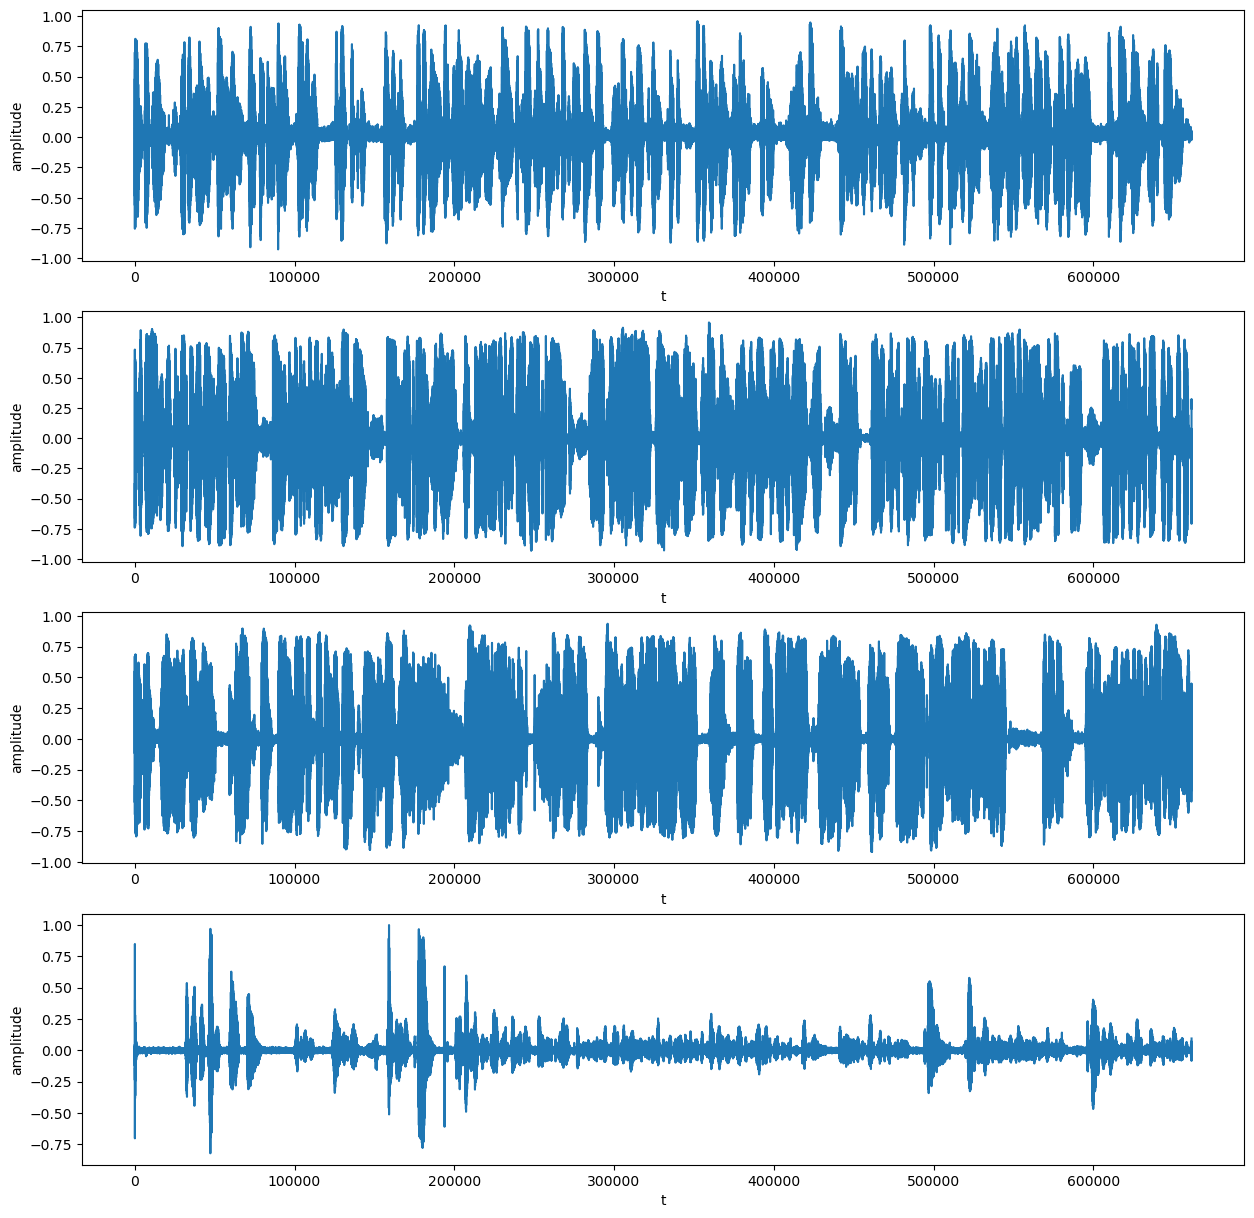

In [7]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(speech_sounds[i])
    plt.xlabel('t')
    plt.ylabel('amplitude')
plt.show()

In [8]:
fft_step=256
fft_size=512
fft_chunks = len(speech_sounds[0])//fft_step

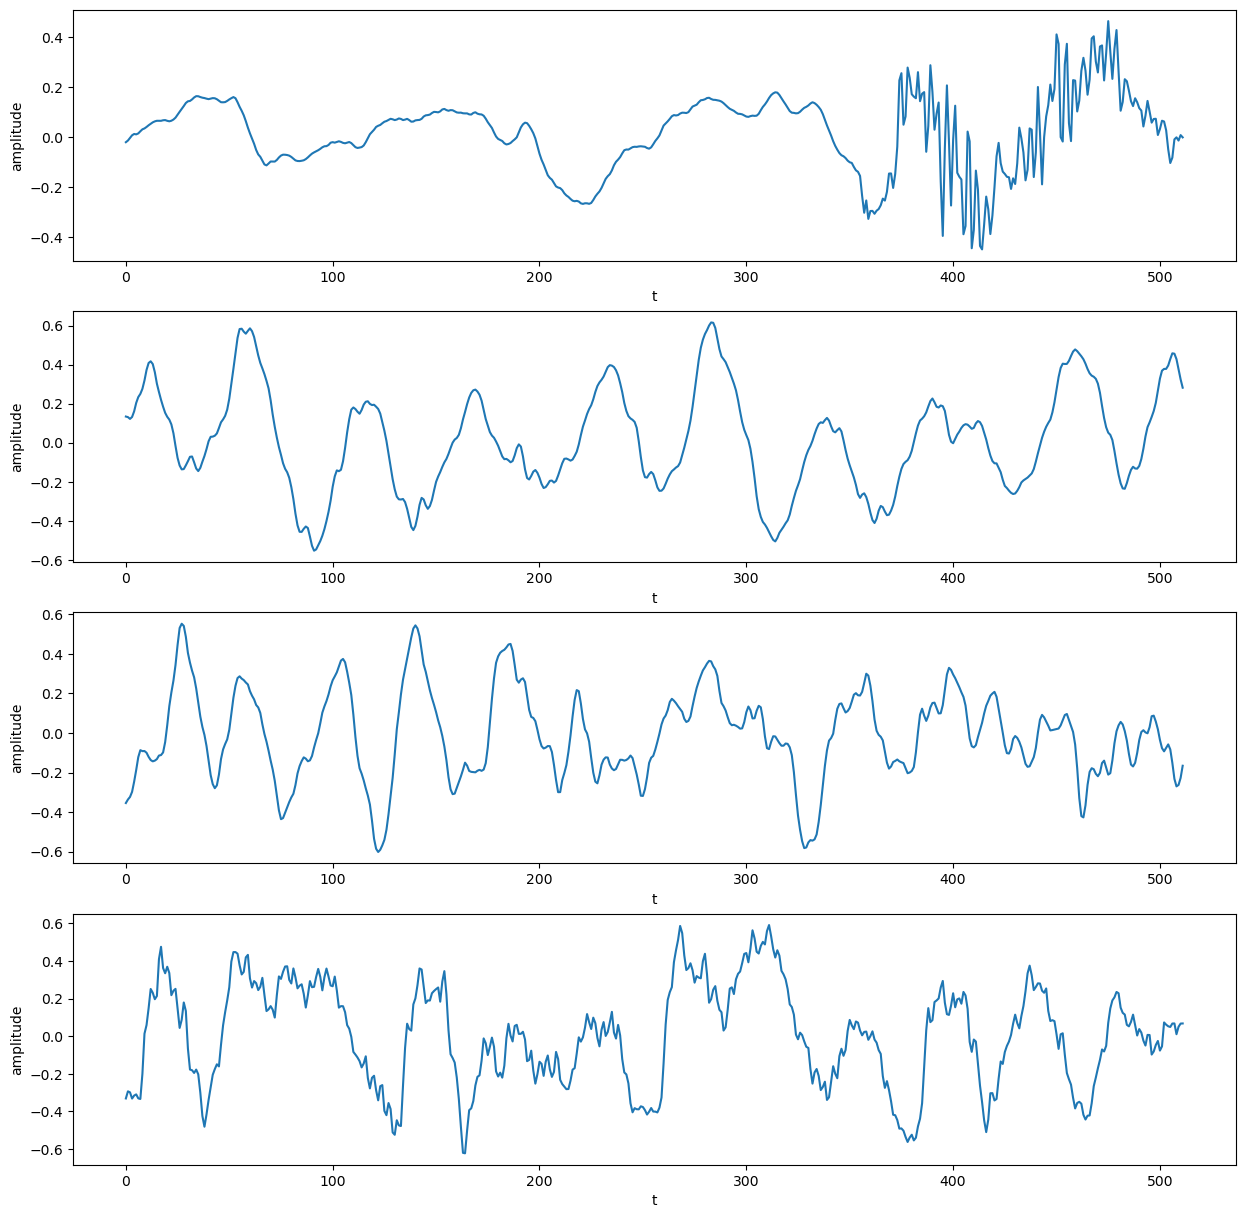

In [9]:
start_ft = 1000
start = start_ft*fft_step

grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(music_sounds[i][start:start+fft_size])
    plt.xlabel('t')
    plt.ylabel('amplitude')
plt.show()

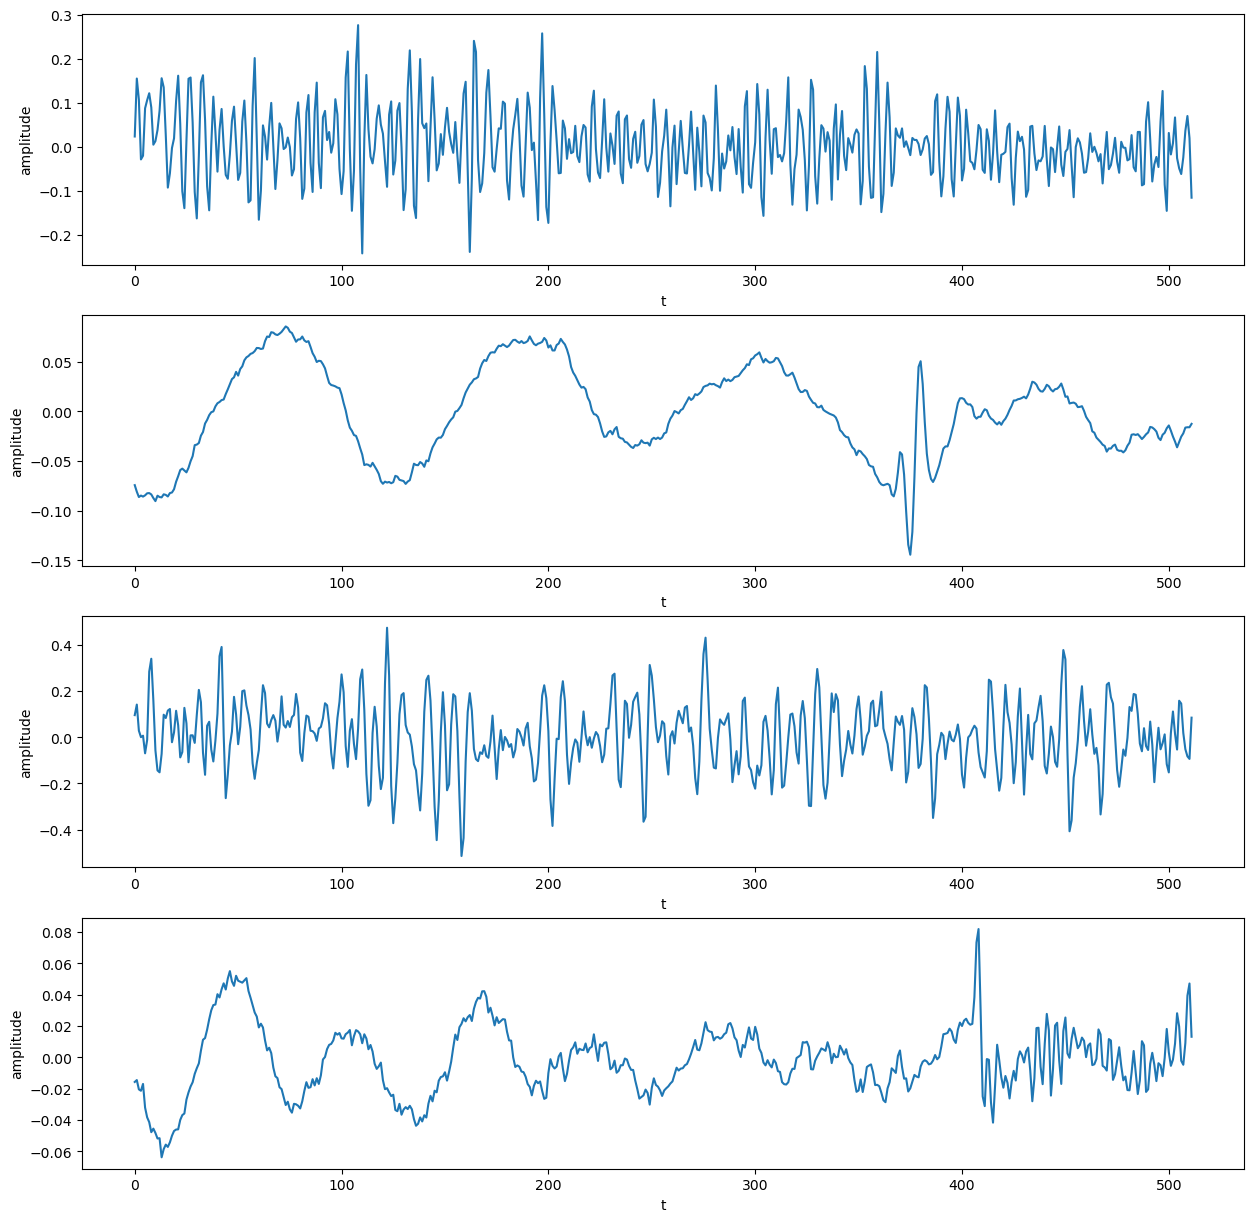

In [10]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(speech_sounds[i][start:start+fft_size])
    plt.xlabel('t')
    plt.ylabel('amplitude')
plt.show()

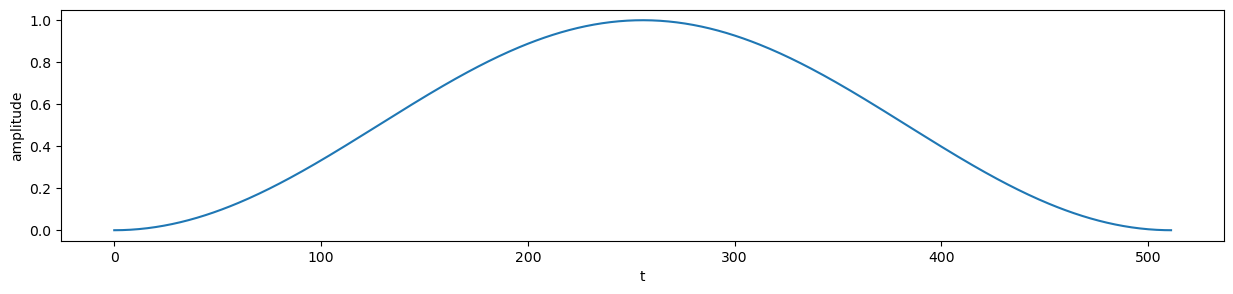

In [11]:
hann_win = hann(fft_size)

plt.figure(figsize=(15,3))
plt.plot(hann_win)
plt.xlabel('t')
plt.ylabel('amplitude')
plt.show()

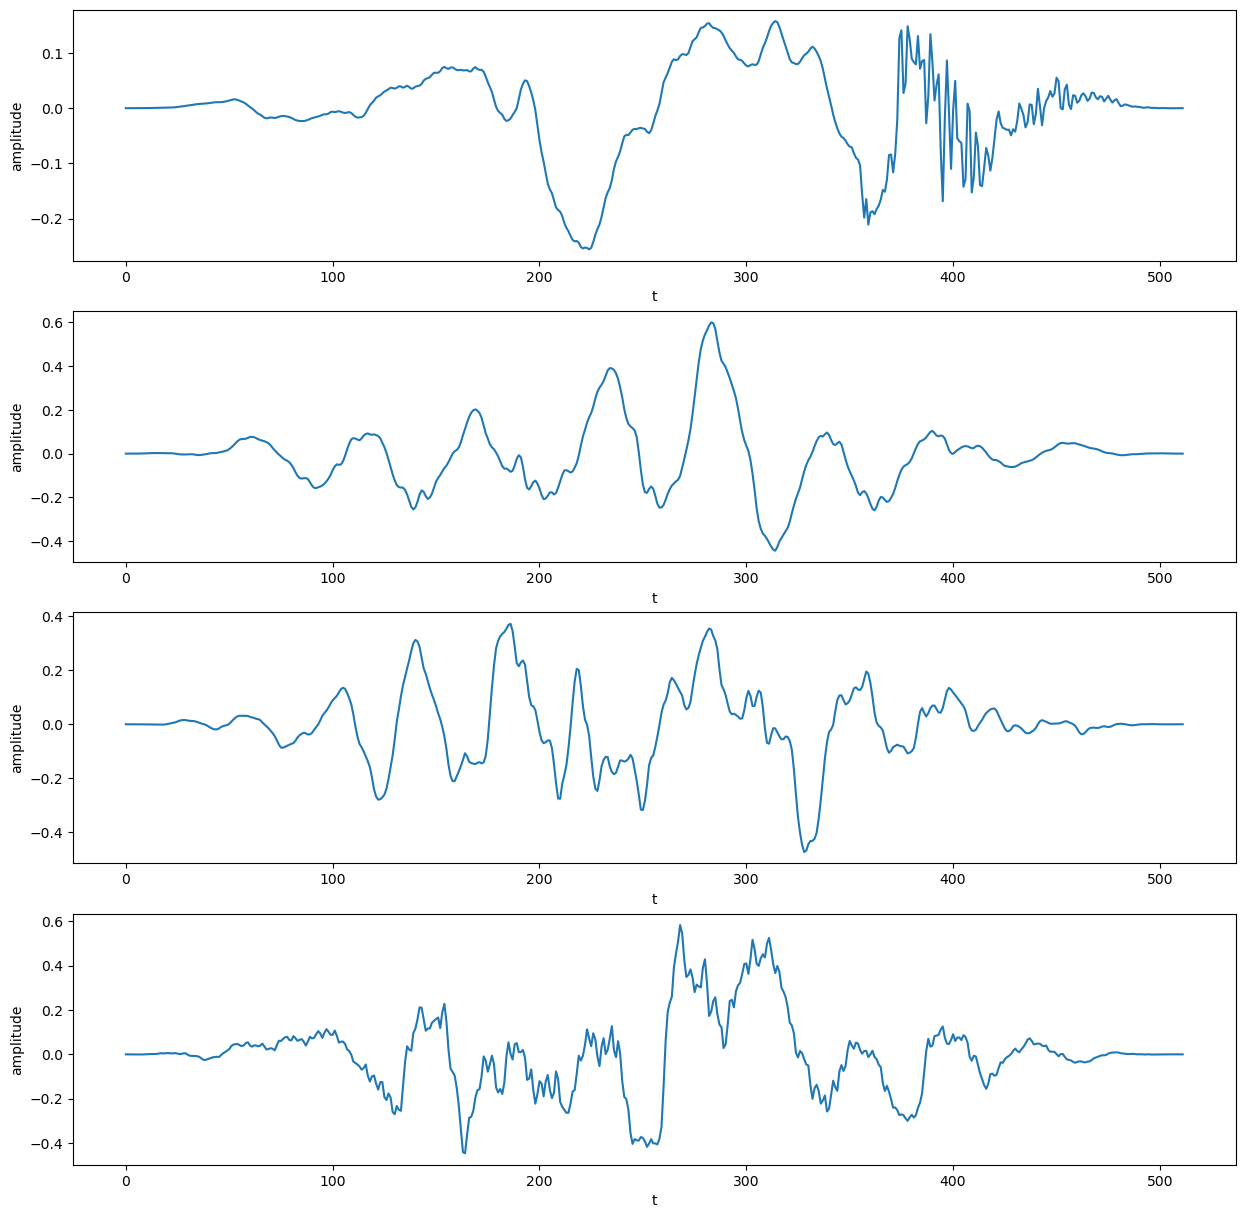

In [12]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(music_sounds[i][start:start+fft_size]*hann_win)
    plt.xlabel('t')
    plt.ylabel('amplitude')
plt.show()

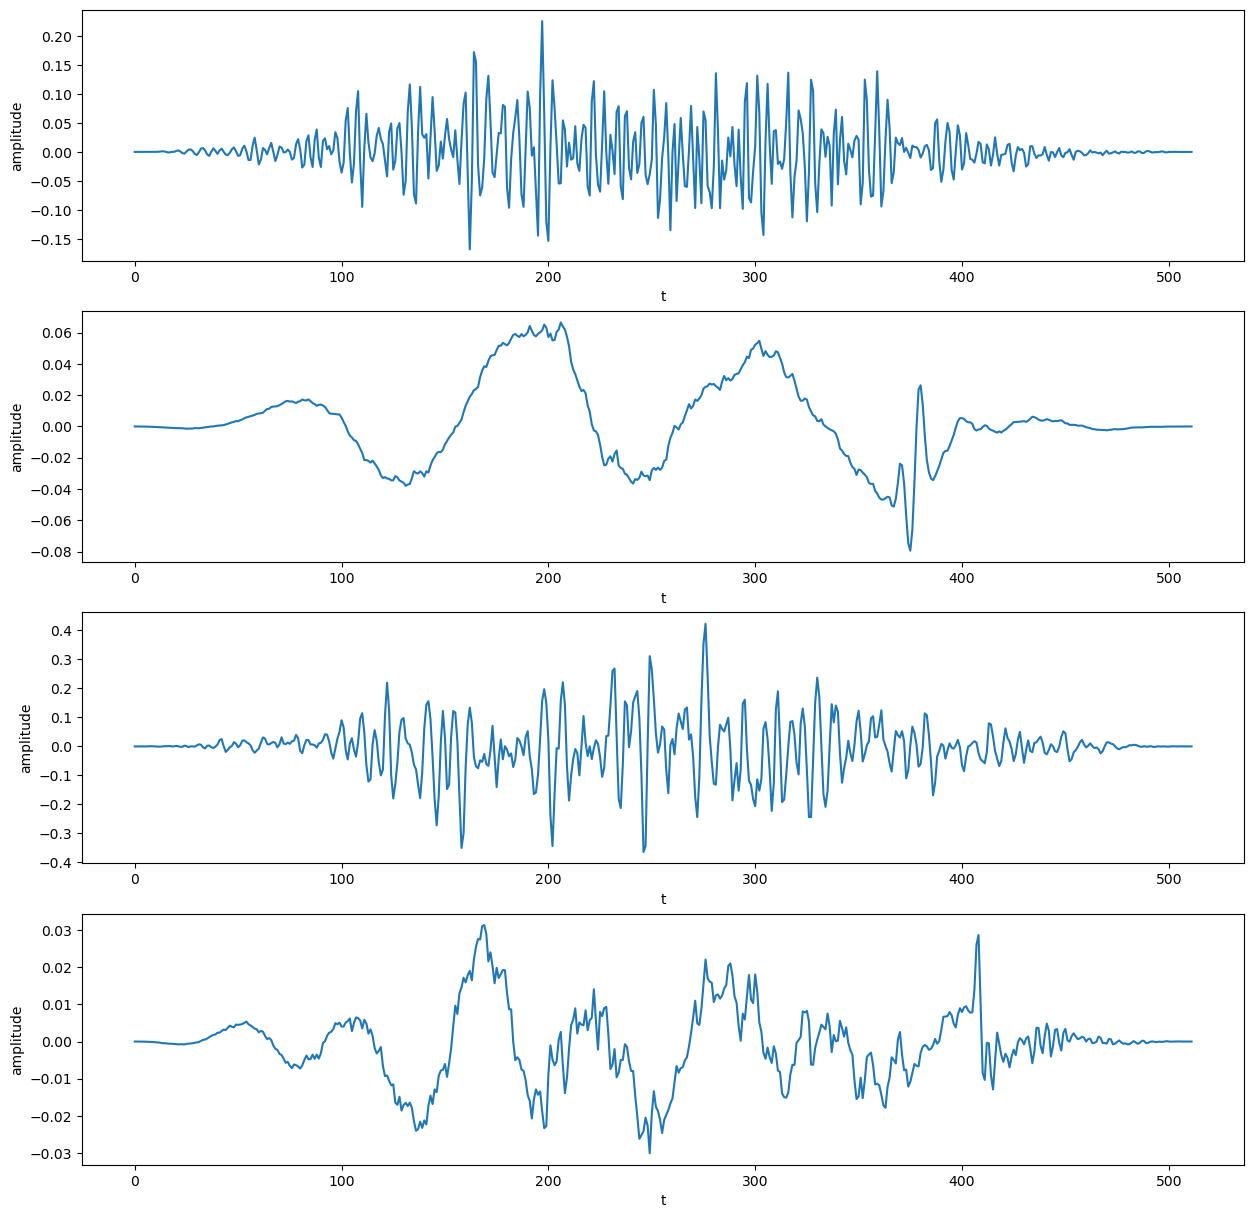

In [13]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(speech_sounds[i][start:start+fft_size]*hann_win)
    plt.xlabel('t')
    plt.ylabel('amplitude')
plt.show()

In [14]:
speech_logmag = dft_logmag(speech_sounds,fft_chunks,fft_step,fft_size)
music_logmag = dft_logmag(music_sounds,fft_chunks,fft_step,fft_size)

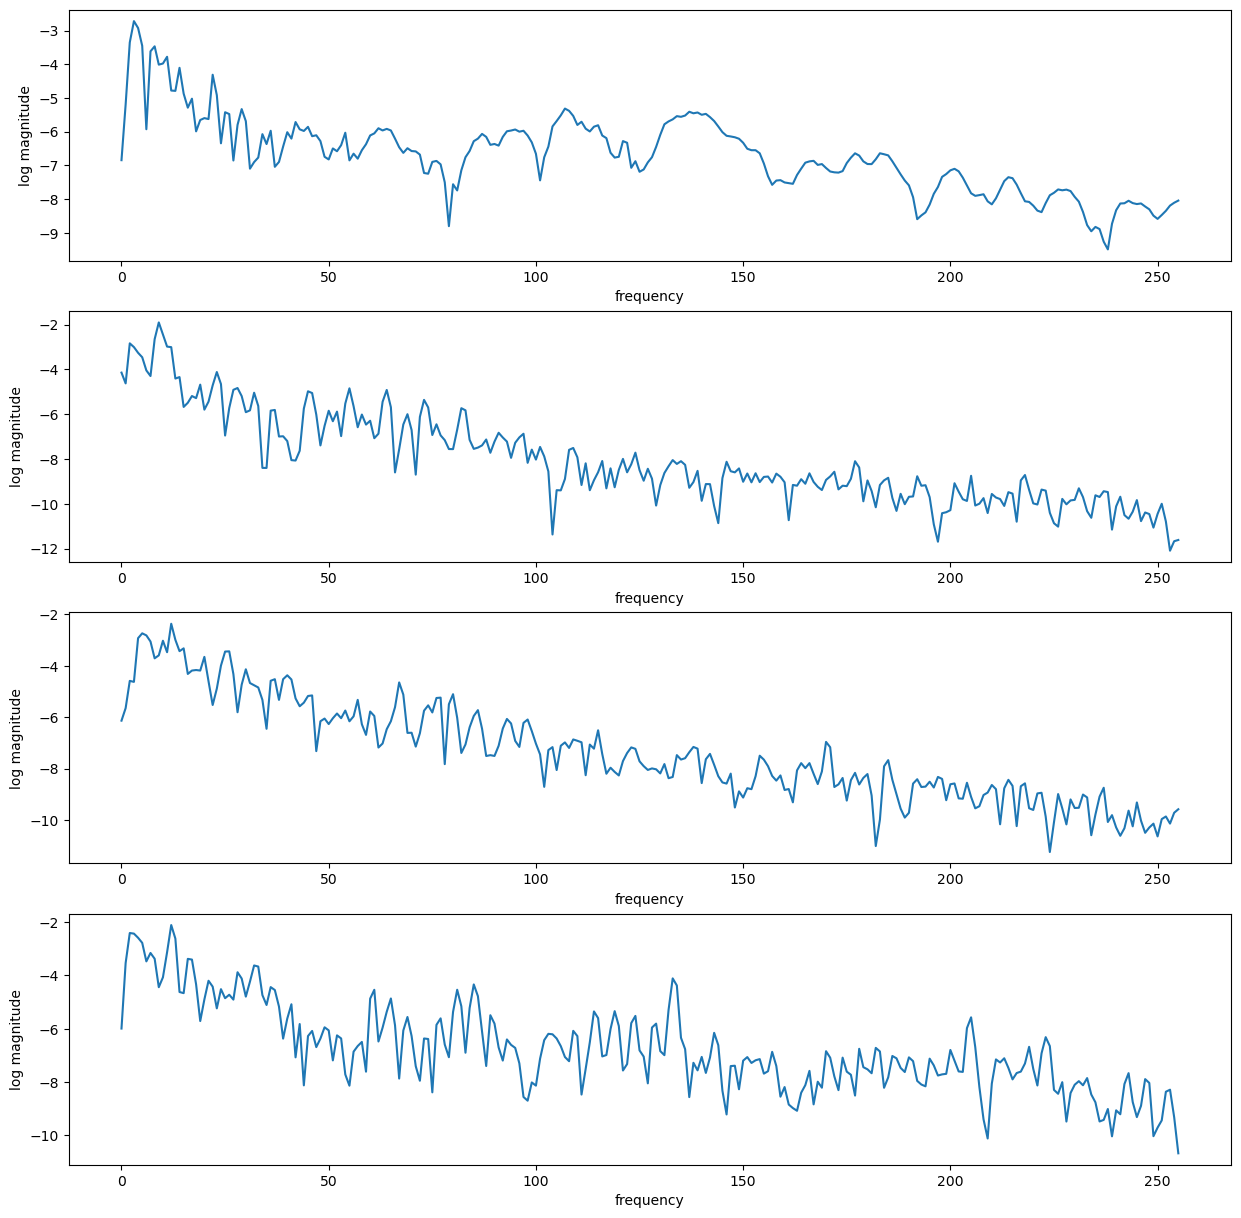

In [15]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(music_logmag[i][start_ft])
    plt.xlabel('frequency')
    plt.ylabel('log magnitude')
plt.show()

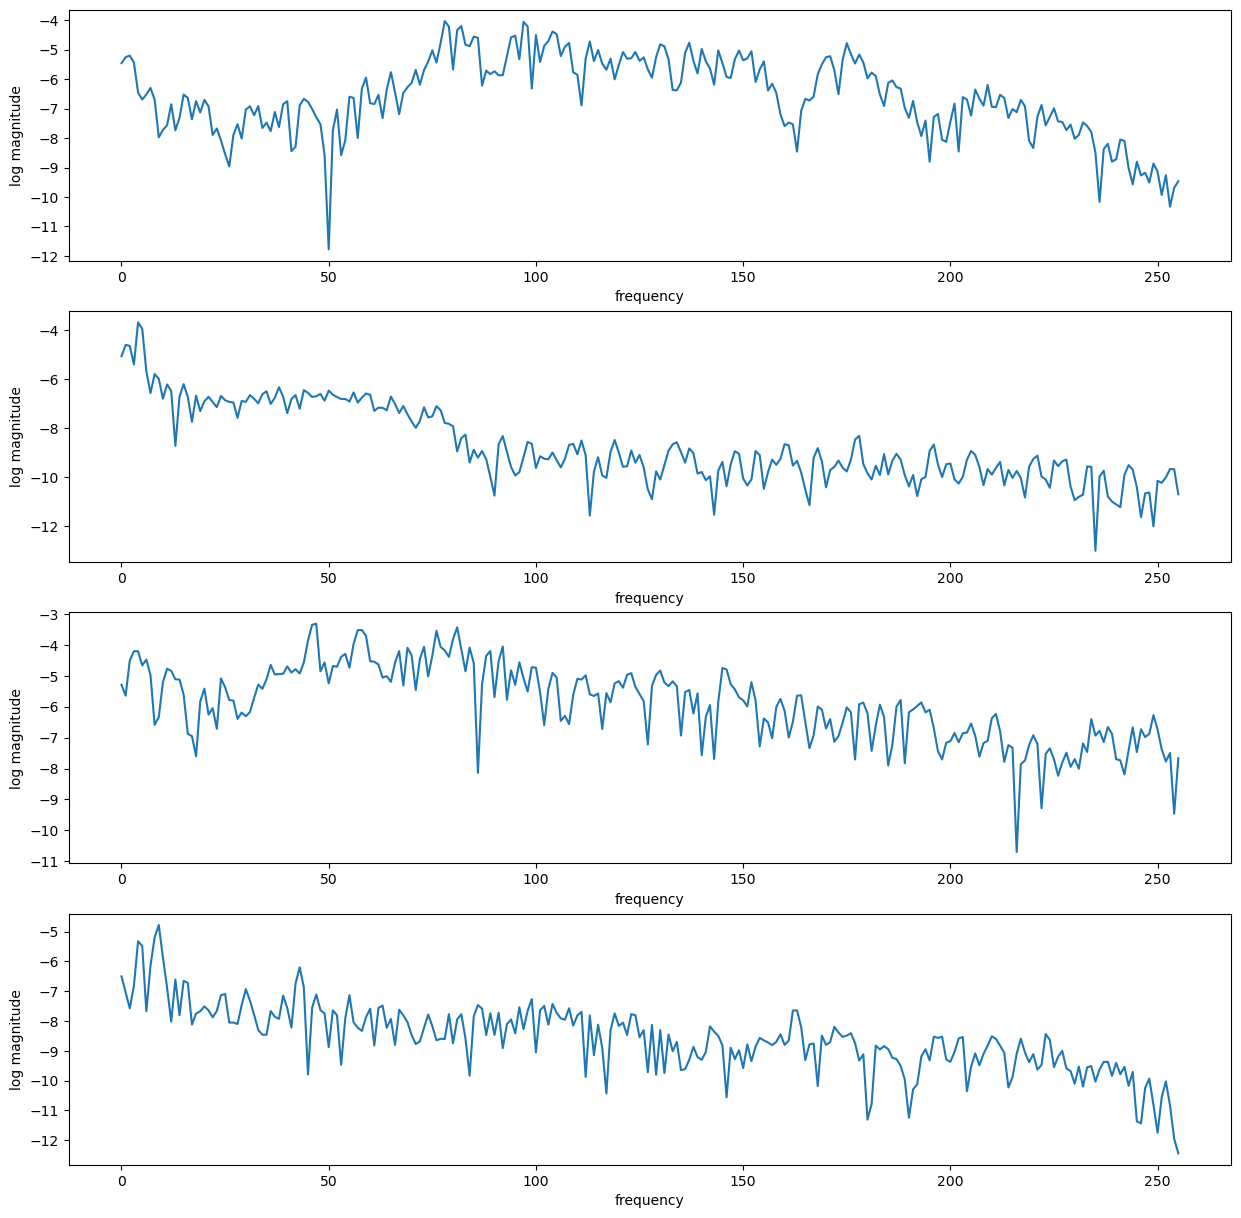

In [16]:
grid = (4,1)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(15,15))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.plot(speech_logmag[i][start_ft])
    plt.xlabel('frequency')
    plt.ylabel('log magnitude')
plt.show()

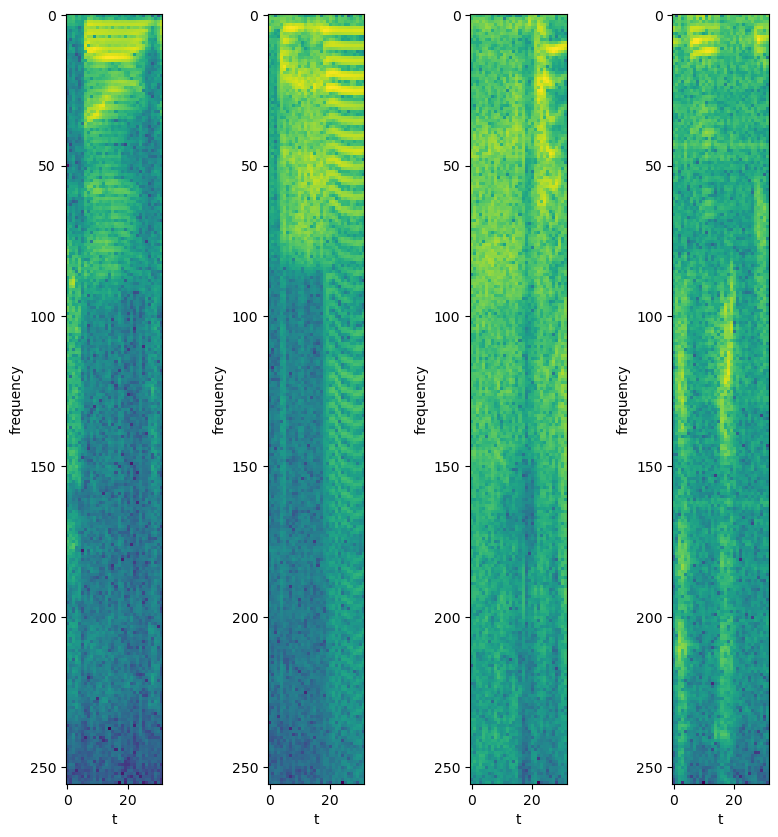

In [17]:
patch_size = 32

grid = (1,4)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(10,10))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.imshow(speech_logmag[i][start_ft:start_ft+patch_size].T)
    plt.xlabel('t')
    plt.ylabel('frequency')
plt.show()

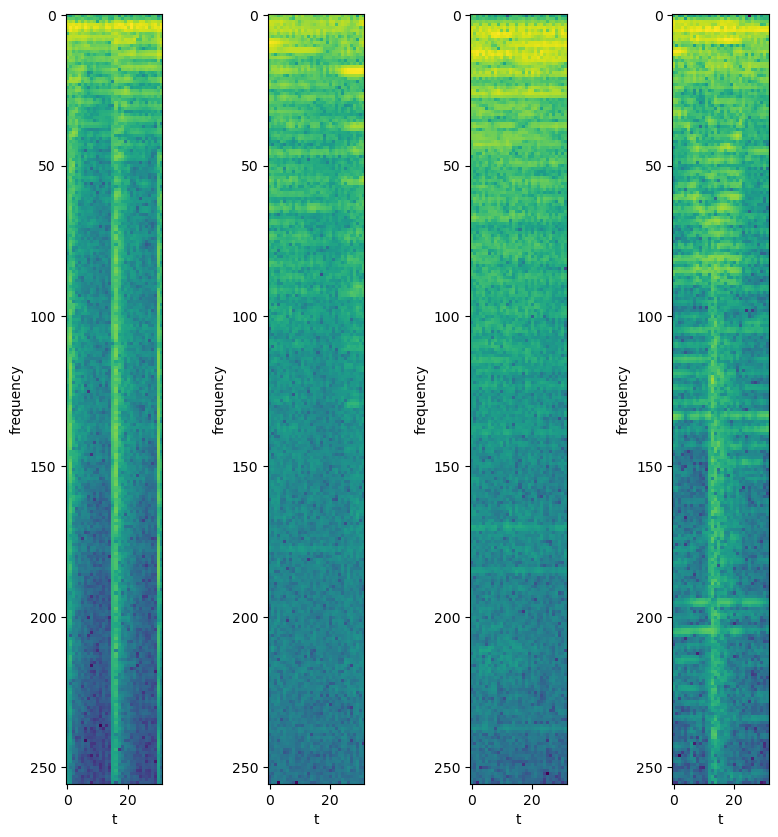

In [18]:
grid = (1,4)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(10,10))
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.imshow(music_logmag[i][start_ft:start_ft+patch_size].T)
    plt.xlabel('t')
    plt.ylabel('frequency')
plt.show()

In [19]:
music_logmag_label = np.insert(music_logmag,256,0.0,axis=2)
speech_logmag_label = np.insert(speech_logmag,256,1.0,axis=2)

sounds_logmag = np.concatenate((music_logmag_label,speech_logmag_label))
print(sounds_logmag.shape)

(128, 2583, 257)


In [20]:
sounds_logmag = sounds_logmag.reshape((-1,861,257))
np.random.shuffle(sounds_logmag)
print(sounds_logmag.shape)

(384, 861, 257)


Labels: [1, 1, 0, 0]


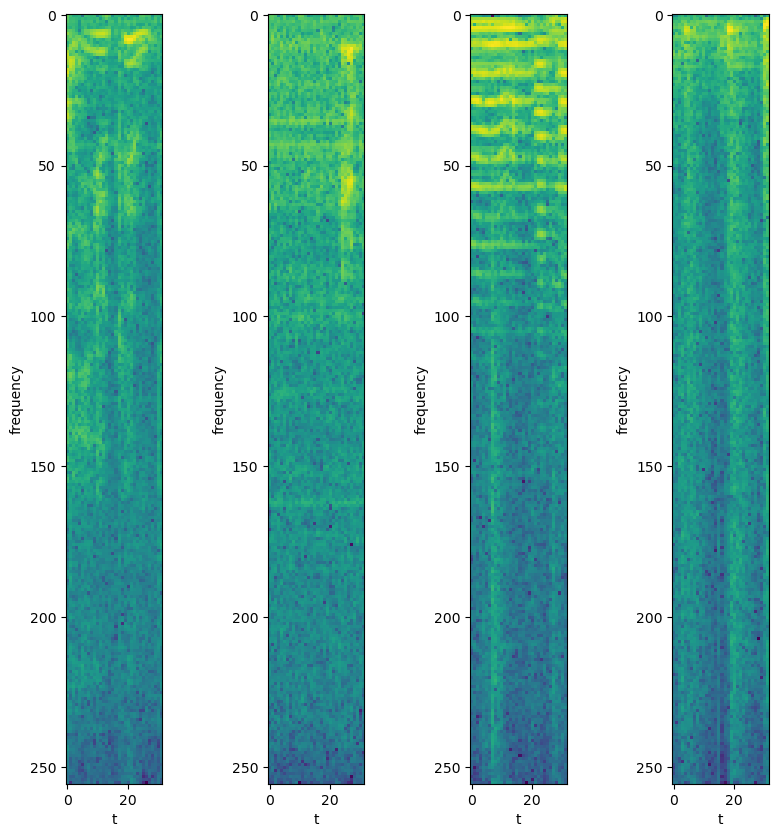

In [21]:
grid = (1,4)
n_grid = grid[0]*grid[1]
plt.figure(figsize=(10,10))
labels =[]
for i in range(n_grid):
    plt.subplot(grid[0],grid[1],i+1)
    plt.imshow(sounds_logmag[i,:patch_size,:-1].T)
    labels+=[int(sounds_logmag[i,0,-1])]
    plt.xlabel('t')
    plt.ylabel('frequency')
print(f"Labels: {labels}")
plt.show()

In [22]:
patch_step = 1

def ds_window(sound):
    ds = tf.data.Dataset.from_tensor_slices(sound)
    ds = ds.window(size=patch_size,shift=patch_step,drop_remainder=True)
    return ds

ds = ds_window(sounds_logmag[0])
for sound in sounds_logmag[1:]: ds = ds.concatenate(ds_window(sound))
ds = ds.flat_map(lambda x: x.batch(patch_size))

ds = ds.map(lambda x: (x[:,:-1], x[0,-1]))

ds = ds.shuffle(5000)
ds = ds.batch(1)

2023-03-06 12:02:46.628471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Labels: [0, 0, 1, 1, 0, 0, 0, 0, 1, 1]


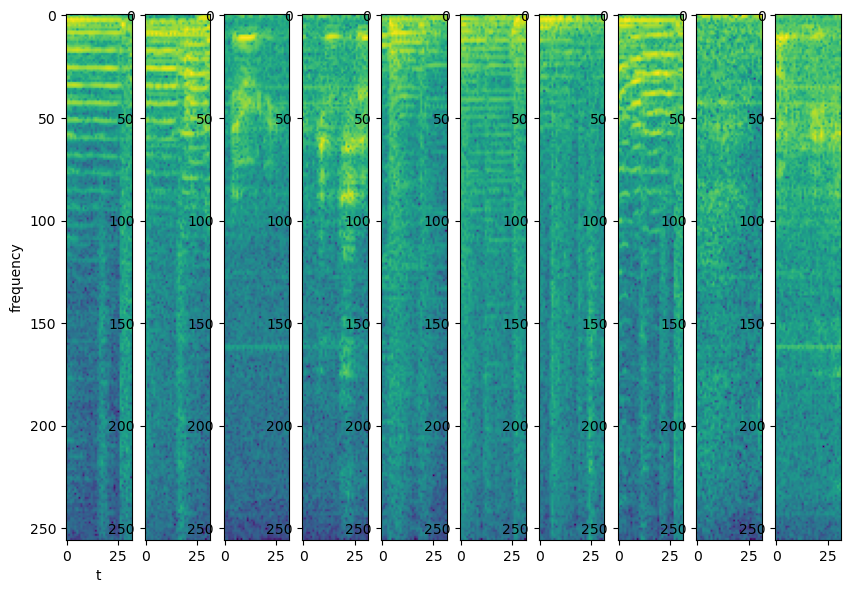

In [23]:
n = 10
labels =[]
plt.figure(figsize=(10,10))
for i, (sound, label) in enumerate(ds.take(n)):
    labels+=[int(label.numpy()[0])]
    plt.subplot(1,n,i+1)
    plt.imshow(sound.numpy()[0].T)
    if i == 0:
        plt.xlabel('t')
        plt.ylabel('frequency')
print(f"Labels: {labels}")
plt.show()
